## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import warnings
warnings.filterwarnings("ignore")

## 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="pandas")

## 3. Read the Data

In [4]:
path = r"D:\Portfolio\Flight-Price-Prediction-using-Amazon-SageMaker\data\train.csv"
train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-21,Delhi,Cochin,17:15:00,19:15:00,1560,2.0,No Info,8245
1,Vistara,2019-05-15,Kolkata,Banglore,07:10:00,10:45:00,1655,1.0,No Info,8452
2,Jet Airways,2019-06-09,Banglore,Delhi,18:55:00,22:00:00,185,0.0,No Info,8016
3,Air India,2019-06-09,Kolkata,Banglore,09:50:00,23:15:00,805,3.0,No Info,14960
4,Spicejet,2019-05-09,Banglore,Delhi,05:55:00,08:35:00,160,0.0,No check-in baggage included,3573
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-03-09,Delhi,Cochin,19:15:00,04:25:00,550,1.0,In-flight meal not included,14053
636,Jet Airways,2019-03-27,Mumbai,Hyderabad,02:55:00,04:25:00,90,0.0,In-flight meal not included,1840
637,Multiple Carriers,2019-06-12,Delhi,Cochin,09:45:00,16:10:00,385,1.0,No Info,9646
638,Indigo,2019-04-15,Banglore,Delhi,22:10:00,01:00:00,170,0.0,No Info,3943


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [6]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations

### 4.1 `airline`

In [7]:
X_train.airline

0              Air India
1                Vistara
2            Jet Airways
3              Air India
4               Spicejet
             ...        
635          Jet Airways
636          Jet Airways
637    Multiple Carriers
638               Indigo
639               Indigo
Name: airline, Length: 640, dtype: object

In [8]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Other
0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
635,0.0,0.0,1.0,0.0
636,0.0,0.0,1.0,0.0
637,0.0,0.0,0.0,1.0
638,0.0,1.0,0.0,0.0


### 4.2 `date_of_journey`

In [9]:
X_train.date_of_journey

0      2019-03-21
1      2019-05-15
2      2019-06-09
3      2019-06-09
4      2019-05-09
          ...    
635    2019-03-09
636    2019-03-27
637    2019-06-12
638    2019-04-15
639    2019-05-09
Name: date_of_journey, Length: 640, dtype: object

In [10]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.176471,0.500000,0.169492
1,0.666667,0.647059,0.333333,0.635593
2,1.000000,0.823529,1.000000,0.847458
3,1.000000,0.823529,1.000000,0.847458
4,0.666667,0.588235,0.500000,0.584746
...,...,...,...,...
635,0.000000,0.058824,0.833333,0.067797
636,0.000000,0.235294,0.333333,0.220339
637,1.000000,0.882353,0.333333,0.872881
638,0.333333,0.411765,0.000000,0.381356


### 4.3 `source` & `destination`

In [11]:
X_train.source

0         Delhi
1       Kolkata
2      Banglore
3       Kolkata
4      Banglore
         ...   
635       Delhi
636      Mumbai
637       Delhi
638    Banglore
639       Delhi
Name: source, Length: 640, dtype: object

In [12]:
X_train.destination

0         Cochin
1       Banglore
2          Delhi
3       Banglore
4          Delhi
         ...    
635       Cochin
636    Hyderabad
637       Cochin
638        Delhi
639       Cochin
Name: destination, Length: 640, dtype: object

In [13]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Kolkata,Banglore
2,Banglore,Delhi
3,Kolkata,Banglore
4,Banglore,Delhi
...,...,...
635,Delhi,Cochin
636,Mumbai,Hyderabad
637,Delhi,Cochin
638,Banglore,Delhi


In [14]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.018030,1.018411
1,-0.079180,-0.096198
2,-1.130315,-1.707797
3,-0.079180,-0.096198
4,-1.130315,-1.707797
...,...,...
635,1.018030,1.018411
636,-1.678967,-1.046938
637,1.018030,1.018411
638,-1.130315,-1.707797


In [15]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [16]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
635,1,0
636,1,0
637,1,0
638,0,1


In [17]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.018030,1.018411,1,0
1,-0.079180,-0.096198,1,0
2,-1.130315,-1.707797,0,1
3,-0.079180,-0.096198,1,0
4,-1.130315,-1.707797,0,1
...,...,...,...,...
635,1.018030,1.018411,1,0
636,-1.678967,-1.046938,1,0
637,1.018030,1.018411,1,0
638,-1.130315,-1.707797,0,1


### 4.4 `dep_time` & `arrival_time`

In [18]:
X_train.dep_time

0      17:15:00
1      07:10:00
2      18:55:00
3      09:50:00
4      05:55:00
         ...   
635    19:15:00
636    02:55:00
637    09:45:00
638    22:10:00
639    08:35:00
Name: dep_time, Length: 640, dtype: object

In [19]:
X_train.arrival_time

0      19:15:00
1      10:45:00
2      22:00:00
3      23:15:00
4      08:35:00
         ...   
635    04:25:00
636    04:25:00
637    16:10:00
638    01:00:00
639    22:30:00
Name: arrival_time, Length: 640, dtype: object

In [20]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,17:15:00,19:15:00
1,07:10:00,10:45:00
2,18:55:00,22:00:00
3,09:50:00,23:15:00
4,05:55:00,08:35:00
...,...,...
635,19:15:00,04:25:00
636,02:55:00,04:25:00
637,09:45:00,16:10:00
638,22:10:00,01:00:00


In [21]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.739130,0.272727,0.826087,0.272727
1,0.304348,0.181818,0.434783,0.818182
2,0.782609,1.000000,0.956522,0.000000
3,0.391304,0.909091,1.000000,0.272727
4,0.217391,1.000000,0.347826,0.636364
...,...,...,...,...
635,0.826087,0.272727,0.173913,0.454545
636,0.086957,1.000000,0.173913,0.454545
637,0.391304,0.818182,0.695652,0.181818
638,0.956522,0.181818,0.043478,0.000000


In [22]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive="left"),
                 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                 X_temp.loc[:, col].between(eve, night, inclusive="left")],
                ["morning", "afternoon", "evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,evening,evening
1,morning,morning
2,evening,night
3,morning,night
4,morning,morning
...,...,...
635,evening,morning
636,night,morning
637,morning,evening
638,night,night


In [23]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.160920,0.617021
1,1.000000,1.000000
2,0.160920,0.936170
3,1.000000,0.936170
4,1.000000,1.000000
...,...,...
635,0.160920,1.000000
636,0.172414,1.000000
637,1.000000,0.617021
638,0.172414,0.936170


In [24]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.739130,0.272727,0.826087,0.272727,0.160920,0.617021
1,0.304348,0.181818,0.434783,0.818182,1.000000,1.000000
2,0.782609,1.000000,0.956522,0.000000,0.160920,0.936170
3,0.391304,0.909091,1.000000,0.272727,1.000000,0.936170
4,0.217391,1.000000,0.347826,0.636364,1.000000,1.000000
...,...,...,...,...,...,...
635,0.826087,0.272727,0.173913,0.454545,0.160920,1.000000
636,0.086957,1.000000,0.173913,0.454545,0.172414,1.000000
637,0.391304,0.818182,0.695652,0.181818,1.000000,0.617021
638,0.956522,0.181818,0.043478,0.000000,0.172414,0.936170


### 4.5 `duration`

In [25]:
X_train.duration

0      1560
1      1655
2       185
3       805
4       160
       ... 
635     550
636      90
637     385
638     170
639     835
Name: duration, Length: 640, dtype: int64

In [26]:
(
    X_train
    .duration
    .quantile([0.25, 0.5, 0.75])
    .values
    .reshape(-1, 1)
    # .shape
)

array([[170.  ],
       [480.  ],
       [976.25]])

In [27]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma


    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }

        return self


    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)

In [28]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,0.904837,0.904837
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,0.904837,0.904837
3,0.000000e+00,0.0,0.670320,0.670320
4,0.000000e+00,0.0,0.904837,0.904837
...,...,...,...,...
635,0.000000e+00,0.0,1.000000,1.000000
636,0.000000e+00,0.0,0.904837,0.904837
637,4.225900e-132,0.0,1.000000,1.000000
638,0.000000e+00,0.0,0.904837,0.904837


In [29]:
def duration_category(X, short=180, med=400):
    return (
        X
        .assign(duration_cat=np.select([X.duration.lt(short),
                                        X.duration.between(short, med, inclusive="left")],
                                       ["short", "medium"],
                                       default="long"))
        .drop(columns="duration")
    )

In [30]:
def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )

In [31]:
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.366504,-0.112926,-0.053577,2.0,1,1.800279
1,-0.366504,-0.112926,-0.053577,2.0,1,1.985423
2,-0.366504,-0.112926,-0.053577,1.0,0,-0.879436
3,-0.366504,-0.112926,-0.053577,2.0,0,0.328872
4,-0.363551,-0.112926,-0.053577,0.0,0,-0.928158
...,...,...,...,...,...,...
635,-0.366504,-0.112926,-0.053577,2.0,0,-0.168093
636,-0.366504,-0.112926,-0.053577,0.0,0,-1.064580
637,-0.366504,-0.112926,-0.053577,1.0,0,-0.489659
638,3.097943,-0.112926,-0.053577,0.0,0,-0.908669


### 4.6 `total_stops`

In [32]:
X_train.total_stops

0      2.0
1      1.0
2      0.0
3      3.0
4      0.0
      ... 
635    1.0
636    0.0
637    1.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [33]:
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,2.0,0
1,1.0,0
2,0.0,1
3,3.0,0
4,0.0,1
...,...,...
635,1.0,0
636,0.0,1
637,1.0,0
638,0.0,1


### 4.7 `additional_info`

In [34]:
X_train.additional_info

0                           No Info
1                           No Info
2                           No Info
3                           No Info
4      No check-in baggage included
                   ...             
635     In-flight meal not included
636     In-flight meal not included
637                         No Info
638                         No Info
639                         No Info
Name: additional_info, Length: 640, dtype: object

In [35]:
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
...,...,...,...
635,1.0,0.0,0.0
636,1.0,0.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [36]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [37]:
info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func=have_info))
])

In [38]:
info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,0.0,1.0,1
...,...,...,...,...
635,1.0,0.0,0.0,1
636,1.0,0.0,0.0,1
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


### 4.8 Column Transformer

In [39]:
column_transformer = ColumnTransformer(transformers=[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", 'destination']),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,1.0,0.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.018030,1.018411,1,0,0.739130,0.272727,0.826087,0.272727,0.160920,0.617021,-0.366504,-0.112926,-0.053577,2.0,1,1.800279,2.0,0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,1.0,0.666667,0.647059,0.333333,0.635593,-0.079180,-0.096198,1,0,0.304348,0.181818,0.434783,0.818182,1.000000,1.000000,-0.366504,-0.112926,-0.053577,2.0,1,1.985423,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,1.000000,0.823529,1.000000,0.847458,-1.130315,-1.707797,0,1,0.782609,1.000000,0.956522,0.000000,0.160920,0.936170,-0.366504,-0.112926,-0.053577,1.0,0,-0.879436,0.0,1,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,1.000000,0.823529,1.000000,0.847458,-0.079180,-0.096198,1,0,0.391304,0.909091,1.000000,0.272727,1.000000,0.936170,-0.366504,-0.112926,-0.053577,2.0,0,0.328872,3.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,1.0,0.666667,0.588235,0.500000,0.584746,-1.130315,-1.707797,0,1,0.217391,1.000000,0.347826,0.636364,1.000000,1.000000,-0.363551,-0.112926,-0.053577,0.0,0,-0.928158,0.0,1,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.000000,0.058824,0.833333,0.067797,1.018030,1.018411,1,0,0.826087,0.272727,0.173913,0.454545,0.160920,1.000000,-0.366504,-0.112926,-0.053577,2.0,0,-0.168093,1.0,0,1.0,0.0,0.0,1
636,0.0,0.0,1.0,0.0,0.000000,0.235294,0.333333,0.220339,-1.678967,-1.046938,1,0,0.086957,1.000000,0.173913,0.454545,0.172414,1.000000,-0.366504,-0.112926,-0.053577,0.0,0,-1.064580,0.0,1,1.0,0.0,0.0,1
637,0.0,0.0,0.0,1.0,1.000000,0.882353,0.333333,0.872881,1.018030,1.018411,1,0,0.391304,0.818182,0.695652,0.181818,1.000000,0.617021,-0.366504,-0.112926,-0.053577,1.0,0,-0.489659,1.0,0,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0.0,0.333333,0.411765,0.000000,0.381356,-1.130315,-1.707797,0,1,0.956522,0.181818,0.043478,0.000000,0.172414,0.936170,3.097943,-0.112926,-0.053577,0.0,0,-0.908669,0.0,1,0.0,1.0,0.0,0


## 5. Feature Selection

In [40]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.1
) 

## 6. Putting it all Together

In [41]:
preprocessor = Pipeline(steps=[
    ("ct", column_transformer),
    ("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,time__arrival_time_hour,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.176471,0.169492,1.018030,1.018411,0.826087,-0.366504,2.0,1,1.800279,2.0,0
1,0.0,0.0,0.647059,0.635593,-0.079180,-0.096198,0.434783,-0.366504,2.0,1,1.985423,1.0,0
2,0.0,1.0,0.823529,0.847458,-1.130315,-1.707797,0.956522,-0.366504,1.0,0,-0.879436,0.0,1
3,0.0,0.0,0.823529,0.847458,-0.079180,-0.096198,1.000000,-0.366504,2.0,0,0.328872,3.0,0
4,0.0,0.0,0.588235,0.584746,-1.130315,-1.707797,0.347826,-0.363551,0.0,0,-0.928158,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.058824,0.067797,1.018030,1.018411,0.173913,-0.366504,2.0,0,-0.168093,1.0,0
636,0.0,1.0,0.235294,0.220339,-1.678967,-1.046938,0.173913,-0.366504,0.0,0,-1.064580,0.0,1
637,0.0,0.0,0.882353,0.872881,1.018030,1.018411,0.695652,-0.366504,1.0,0,-0.489659,1.0,0
638,1.0,0.0,0.411765,0.381356,-1.130315,-1.707797,0.043478,3.097943,0.0,0,-0.908669,0.0,1


## 7. Visualizations

In [42]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.0034059137632333667,
 'air__airline_Indigo': 0.16797401575219448,
 'air__airline_Jet Airways': 0.23764750400578064,
 'air__airline_Other': 0.03757881224396886,
 'doj__date_of_journey_month': 0.050103801572771424,
 'doj__date_of_journey_week': 0.1149891951395526,
 'doj__date_of_journey_day_of_week': -0.01791616844688093,
 'doj__date_of_journey_day_of_year': 0.13720179950149605,
 'location__source': 0.14427511870034512,
 'location__destination': 0.15985660506535868,
 'location__source_is_north': 0.06275249947837529,
 'location__destination_is_north': 0.06275249947837529,
 'time__dep_time_hour': -0.02854957132205871,
 'time__dep_time_minute': 0.012093334017344396,
 'time__arrival_time_hour': 0.11273464470805143,
 'time__arrival_time_minute': 0.049845725370141425,
 'time__dep_time_part_of_day': -0.0028867725546559697,
 'time__arrival_time_part_of_day': 0.05052164179075547,
 'dur__duration_rbf_25': 0.12995271040238054,
 'dur__duration_rbf_50': -0.004008096278775

In [43]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_hour': -0.02854957132205871,
 'doj__date_of_journey_day_of_week': -0.01791616844688093,
 'info__additional_info_No Info': -0.006683417875301467,
 'info__additional_info': -0.006683417875301467,
 'dur__duration_rbf_50': -0.004008096278775852,
 'time__dep_time_part_of_day': -0.0028867725546559697,
 'dur__duration_rbf_75': -0.002753911693853972,
 'info__additional_info_In-flight meal not included': 0.0010705883495311836,
 'air__airline_Air India': 0.0034059137632333667,
 'time__dep_time_minute': 0.012093334017344396,
 'info__additional_info_Other': 0.03398581191859503,
 'air__airline_Other': 0.03757881224396886,
 'time__arrival_time_minute': 0.049845725370141425,
 'doj__date_of_journey_month': 0.050103801572771424,
 'time__arrival_time_part_of_day': 0.05052164179075547,
 'location__source_is_north': 0.06275249947837529,
 'location__destination_is_north': 0.06275249947837529,
 'time__arrival_time_hour': 0.11273464470805143,
 'doj__date_of_journey_week': 0.1149891951395526,

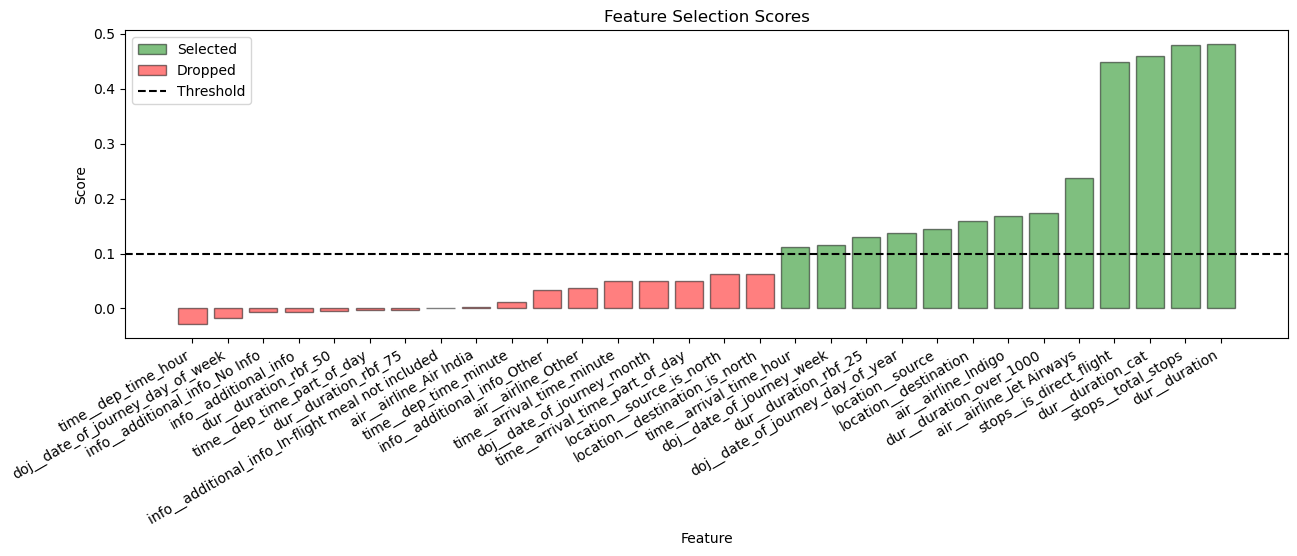

In [44]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
    params = dict(
        x=i,
        height=score,
        edgecolor="black",
        alpha=0.5
    )
    
    if score < THRESHOLD:
        bar = ax.bar(
            color="red",
            **params
        )
        if not dropped_bar:
            dropped_bar = bar[0]
    else:
        bar = ax.bar(
            color="green",
            **params
        )
        if not selected_bar:
            selected_bar = bar[0]

thresh_line = ax.axhline(
    y=0.1,
    color="black",
    linestyle="--"
)

ax.set_xticks(
    ticks=range(len(sorted_feat_imp)),
    labels=list(sorted_feat_imp.keys()),
    rotation=30,
    ha="right"
)

ax.set(
    xlabel="Feature",
    ylabel="Score",
    title="Feature Selection Scores"
)

ax.legend(
    handles=[selected_bar, dropped_bar, thresh_line],
    labels=["Selected", "Dropped", "Threshold"],
    loc="upper left"
)

plt.show()

**Observations**:

- The dataset went upto 31 columns after Feature Engineering.
- The Feature Selection algorithm selected 13 features out of 31 features.